<a href="https://colab.research.google.com/github/pjmartel/embryo_tool/blob/main/embryo_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-abstract with photos. 
Text goes here. 


In [2]:
#@title <--- Click play to initialize
# Import modules
from google.colab import files
from IPython.display import display, Markdown, clear_output
from ipywidgets import Button, Layout, Dropdown, Output, VBox, HBox
import numpy as np
from matplotlib import pyplot as plt, style
#style.use('seaborn-darkgrid')
style.use('ggplot')
import seaborn as sb
import pandas as pd
from google.colab import auth
from scipy.stats import linregress
import gspread
from oauth2client.client import GoogleCredentials
from warnings import filterwarnings
filterwarnings("ignore")

##
def linreg_interval(x,y,interval=0.95):
  """
  Linear regression with confidence intervals.
  """
  import numpy as np
  from scipy.stats import t

  def sdmean(p):
    """
    Computes the sum square devation from the mean.
    """
    return np.var(p,ddof=0)*len(p)

  def SSD(p,q):
    """
    Computes the sum of squares deviation between two data vectors.
    """
    return ((p-q)**2).sum()

  N = len(x)
  mhat, bhat = np.polyfit(x,y,deg=1)
  yhat = x*mhat + bhat
  resi = SSD(y,yhat)

  gamma = 1-interval
  SDM = sdmean(x)
  sem = np.sqrt(resi/(N-2)/SDM)
  seb = sem*np.sqrt((x**2).mean())
  tval = t.ppf(1-gamma/2,df=N-2)
  return mhat, bhat, 1-resi/sdmean(y), np.corrcoef(x,y)[0,1],\
        (mhat-sem*tval, mhat+sem*tval), (bhat-seb*tval, bhat+seb*tval)

##
def read_data(gc_auth, spreadsheet, worksheet="", list=False):
  
  try:
    s = gc_auth.open(spreadsheet)
  except:
    print(f"Spreadsheet file '{spreadsheet}' not found in google drive.")
    return None

  ws_list = [s.title for s in gc.open(spreadsheet).worksheets()]  
  if list:
    print(ws_list)
    return
  if worksheet not in ws_list:
    print(f"The worksheet '{worksheet}' is not part of '{spreadsheet}'")
    return None
  else:
    w = gc.open(spreadsheet).worksheets()[ws_list.index(worksheet)]
    rows = w.get_all_values()
    # Pop the top row containting the headers
    headers = rows.pop(0)
    print(f"The worksheeet '{worksheet}' contains the following headers:")
    print(headers)
    # Create a data frame from the row list, usaing 
    # the sheet header as column labels. 
    df = pd.DataFrame.from_records(rows, columns=headers)
    print(f"reading a {df.shape} worksheet table into a dataframe")
    return df

## C-pPL	C-PS	C-N	N-pPL	PS	PSM	C-Seg	Seg	C-HF	HHStage	Embryo	CultureType
def clean_data(df):

  # Data Labels
  labels_num = ['TimePoint', 'C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 
             'C-Seg', 'Seg', 'C-HF', 'HHStage']
  labels_txt = ['Embryo', 'CultureType']
  type_dict = dict.fromkeys(labels_num,'float32')
  type_dict.update(dict.fromkeys(labels_txt,'str'))
  # Replace null strings by nan
  df.replace('', np.nan,inplace=True)
  # Convert decimal commas to points
  df.replace(to_replace=r'([0-9]),([0-9])',
             value=r'\1.\2', 
             regex=True, 
             inplace=True)
  #data_ref.shape
  df = df.astype(type_dict)
         
  df.dropna(axis='index',how='all',subset=labels_num[1:-1],inplace=True)
  print(f"After cleaning, the new data frame size is {df.shape}")
  return df

##
def regplot_with_bands(ax, x_var, y_var, data, sigma=3.0, 
                       scatter=True, limits=False,lb_prefix=""):

  from seaborn import regplot
  from scipy.stats import linregress
  import numpy as np 

  data_clean = data[[x_var, y_var]].dropna(axis=0, how='any')
  x = np.array(data_clean[x_var])
  y = np.array(data_clean[y_var])
  p = np.argsort(x)
  x = x[p]
  y = y[p]
  m, b, r, _, _ = linregress(x, y)
  # calc variance of data
  y_hat = m * x + b
  yy = y - y_hat
  yy_var = yy.var(ddof=2)
  yy_std = np.sqrt(yy_var)
  ax.plot(x, y_hat + sigma*yy_std,'g--')
  ax.plot(x, y_hat - sigma*yy_std,'g--')
  #_, _, _, _, m_int, b_int = linreg_interval(temp_data['Med9'], temp_data[c])
  label = f"{y_var}: m={m:5.3f} b={b:5.3f}  r2={r*r:5.3f} -- var={yy_var:6.4f}"
  label = lb_prefix + label
  if limits:
    ax.set_xlim(min(x),max(x))
  regplot(x=x_var, y=y_var, data=data_clean, label=label,
          scatter=scatter, ax=ax)
  return label, m, b, r, yy_var

def export_button(fig, name):
  def on_button_clicked(_):
    fig.savefig(name, bbox_inches='tight')
    files.download(name)

  button = Button(description='Export plot to PDF')
  button.on_click(on_button_clicked)
# displaying button and its output together
  display(button)


In [3]:
#@title <--- Grant access to the user's Google Drive
auth.authenticate_user()
try:
  gc = gspread.authorize(GoogleCredentials.get_application_default())
except:
  print("Failed to authorize google drive access with given credentials.")

In [4]:
#@title <--- Read Google spreadsheet with data
spread = "Grelha_Martel_Tool_OnlyMainData" #@param ['Grelha_Martel_Tool_OnlyMainData'] {allow-input: true}
try:
  read_data(gc, spread,list=True)
except:
  print("Failed to read spreadsheet ", spread, "from Google Drive")

['ALLRaw_DATA', 'AllRaw_Data_RealTime', 'Experiments_SingleObservations', 'Experiments_ObservationsOverTim']


In [5]:
#@title <--- Read the worksheets from the spreadsheet
data_ref = read_data(gc, spread,"ALLRaw_DATA")
data_ref = clean_data(data_ref)
print()
data_xper_single = read_data(gc, spread,
                            "Experiments_SingleObservations")
data_xper_single = clean_data(data_xper_single)
print()
data_xper_multi = read_data(gc, spread,
                             "Experiments_ObservationsOverTim")
data_xper_multi = clean_data(data_xper_multi)



The worksheeet 'ALLRaw_DATA' contains the following headers:
['NumberMeasuredFrames', 'TimePoint', 'C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 'C-Seg', 'Seg', 'C-HF', 'HHStage', 'Embryo', 'CultureType']
reading a (416, 14) worksheet table into a dataframe
After cleaning, the new data frame size is (228, 14)

The worksheeet 'Experiments_SingleObservations' contains the following headers:
['NumberMeasuredFrames', 'TimePoint', 'C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 'C-Seg', 'Seg', 'C-HF', 'HHStage', 'Embryo', 'CultureType']
reading a (28, 14) worksheet table into a dataframe
After cleaning, the new data frame size is (28, 14)

The worksheeet 'Experiments_ObservationsOverTim' contains the following headers:
['NumberMeasuredFrames', 'TimePoint', 'C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 'C-Seg', 'Seg', 'C-HF', 'HHStage', 'Embryo', 'CultureType']
reading a (30, 14) worksheet table into a dataframe
After cleaning, the new data frame size is (30, 14)


# Mesuarements over time

Plot all measures as a function of Time or Measures C-N or C-HF. Points are colored by measure. 

Button(description='Export plot to PDF', style=ButtonStyle())

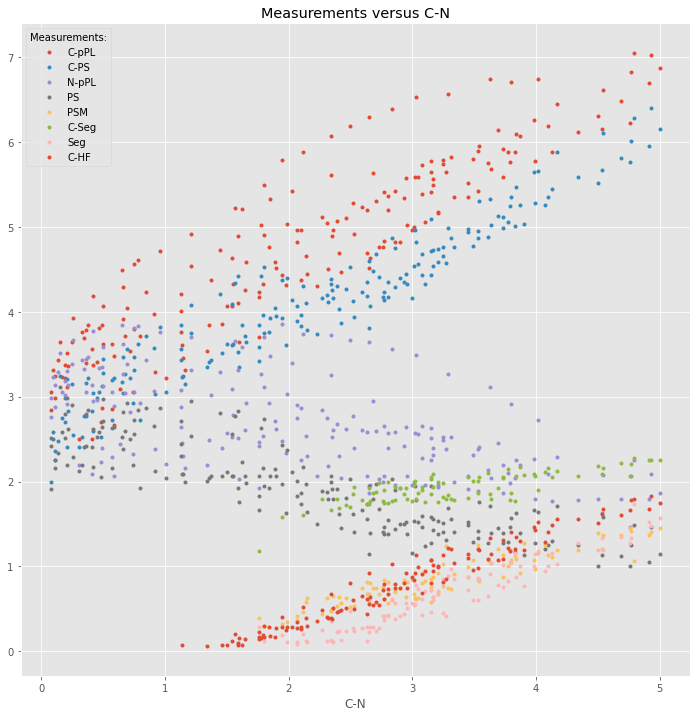

In [7]:
#@title  {run: "auto"}
##@title Measurements over time {run: "auto"}
# Plot all measures as a function of Measure 9 (head size)
# empty linestyle is used with marker style '.' to produce 
# colored markers per measure. Lines won't work because data 
# is not monotonic with time

#Export Button

#button = Button(description='Export plot to PDF')
##out2 = widgets.Output()
#def on_button_clicked(_):
#  # "linking function with output"
#  # linking button and function together using a button's method
#  fig.savefig("measure_over_time.pdf")
#  files.download("measure_over_time.pdf")

#button.on_click(on_button_clicked)
## displaying button and its output together
#display(button)

fig, ax = plt.subplots()
fig.set_facecolor("white")
all_measures = ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 
               'C-Seg', 'Seg', 'C-HF']

export_button(fig, "measure_over_time.pdf")

x_var = 'C-N' #@param ['TimePoint','C-N','C-HF']

#  all_measures.remove('TimePoint')
_ = data_ref.plot(ax=ax, 
                  x=x_var,
                  y=[it for it in all_measures if it!=x_var],
                  kind='line',
                  figsize=(12,12),
                  marker='.', 
                  linestyle=' ',
                  title=f"Measurements versus {x_var}")
_ = ax.legend(title="Measurements:")
#fig.savefig("test.pdf")
#files.download("test.pdf")
###

#  Linear fitting of measurements with confidence intervals 
Plots of measurements against time or other measures are fitted with a linear regression model and confidence intervals for the regression parameters are produced according to chosen statistical significance for the interval.  

Button(description='Export plot to PDF', style=ButtonStyle())

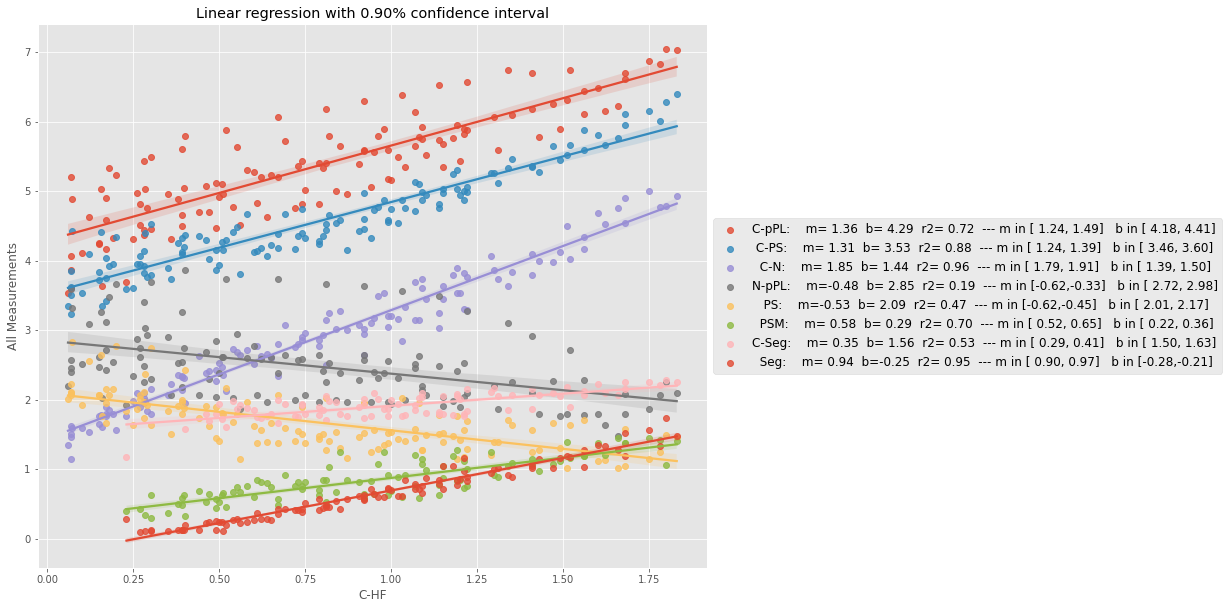

In [9]:
#@title {run: "auto"}
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('large')
fig, ax = plt.subplots(figsize=(12,10))
fig.set_facecolor("white")

export_button(fig,"linear_confidence.pdf")

confidence_interval = "0.9" #@param [ 0.90, 0.95, 0.99]
confidence_interval = eval(confidence_interval)
x_var = 'C-HF' #@param ['C-N','C-HF', 'TimePoint']
ax.set_title(f"Linear regression with {confidence_interval:.2f}% confidence interval")
for c in all_measures:
  if x_var == c:
    continue
  temp_data = data_ref[[x_var, c]].copy()
  temp_data.dropna(axis=0, how='any', inplace=True)
  m, b, r, _, _ = linregress(temp_data[x_var], temp_data[c])
  _, _, _, _, m_int, b_int = linreg_interval(temp_data[x_var], 
                                             temp_data[c], 
                                             confidence_interval)
  label = f"{c:>5}:    m={m:5.2f}  b={b:5.2f}  r2={r*r:5.2f}"
  label = label + "  --- m in [{:5.2f},{:5.2f}]   b in [{:5.2f},{:5.2f}]".format(*m_int,*b_int)
  sb.regplot(ax=ax, x=x_var, y=c,data=data_ref, label=label)

#_ = ax.legend(bbox_to_anchor=(1,0.65))
_ = ax.set_ylabel("All Measurements")
_ = ax.legend(bbox_to_anchor=(1.,0.5), loc=('center left'),prop=fontP)


# Residual Plots
Residual plots for the linear fittings of measuarements against time or other measurements. 

Button(description='Export plot to PDF', style=ButtonStyle())

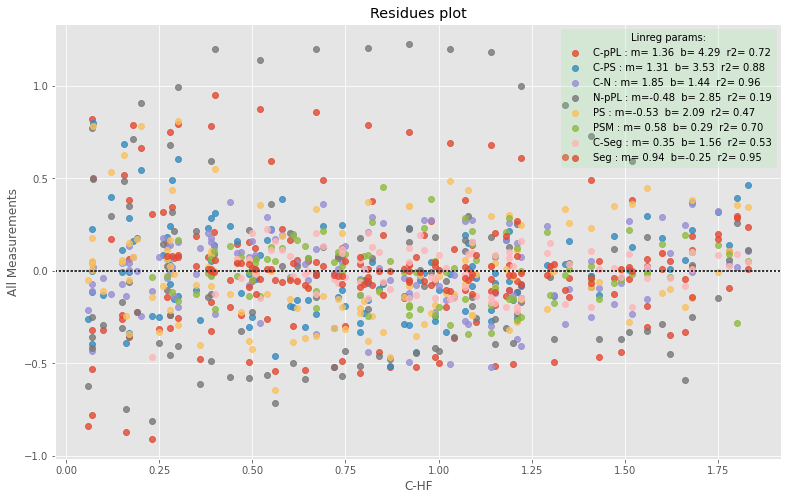

In [17]:
#@title  {run: "auto"}
fig, ax = plt.subplots(figsize=(13,8))
fig.set_facecolor('white')
export_button(fig, "residuals.pdf")
data = data_ref.loc[:,all_measures[0]:all_measures[-1]]
data = data_ref
y_measures = all_measures
#y_measures = ['Med9','Med3']
x_measure = 'C-HF' #@param ['C-N', 'C-HF', 'TimePoint']
for c in [m for m in y_measures if m!=x_measure]:
  temp_data = data[[x_measure,c]].copy()
  temp_data.dropna(axis=0, how='any', inplace=True)
  x = np.array(temp_data[x_measure])
  y = y= np.array(temp_data[c])
  p = np.argsort(x)
  x = x[p]
  y = y[p]
  m, b, r, _, _ = linregress(x, y)
  # calc variance of data
  y_hat = m * x + b
  yy = y - y_hat
  yy_var = yy.var(ddof=2)
  yy_std = np.sqrt(yy_var)
  #ax.plot(x, y_hat + 3*yy_std,'g--')
  #ax.plot(x, y_hat - 3*yy_std,'g--')
  #_, _, _, _, m_int, b_int = linreg_interval(temp_data['Med9'], temp_data[c])
  label = f" : m={m:5.2f}  b={b:5.2f}  r2={r*r:5.2f}"
  label = c + label
  #label = label + "  --- m in [{:5.2f},{:5.2f}]   b in [{:5.2f},{:5.2f}]".format(*m_int,*b_int)
  sb.residplot(x=x_measure, y=c,data=data, label=label,ax=ax)
_ = ax.set_ylabel("All Measurements")  
_ = ax.legend(facecolor="lightgreen",
              title="Linreg params:",
              framealpha=0.2, 
              shadow=False,
              frameon=True)
_ = ax.set_title("Residues plot")

# Confidence bands for measurements
Linear regression plots of single measurements with confidence bands at a set number of standard deviations from the regression estimates. Convenient for the detection of outliers. 

5.0

Button(description='Export plot to PDF', style=ButtonStyle())

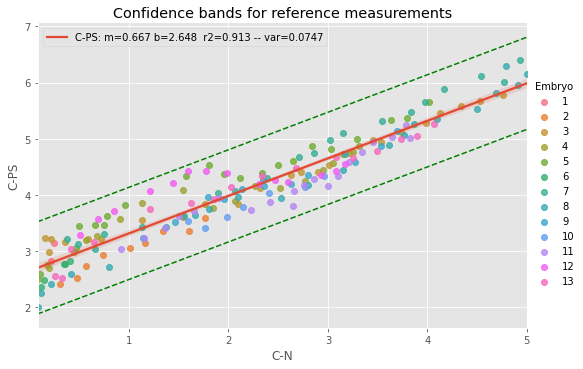

In [14]:
#@title  {run: "auto"}
# Reference experiment, colored by embryo

x_measure = 'C-N' #@param ['C-N','C-HF', 'TimePoint']
y_measure = 'C-PS' #@param ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 'C-Seg', 'Seg', 'C-HF']
sigma = '3' #@param ['1', '2', '3', '4']
color_by_embryo = "yes" #@param ['no','yes']
color_by_embryo = color_by_embryo == "yes"
sigma = float(sigma) # confidence level

legend = color_by_embryo
scatter = not legend

g = sb.lmplot(x=x_measure,y=y_measure,aspect=1.5, data=data_ref,
              hue='Embryo', legend=legend, fit_reg=False)
fig = plt.gcf()
display(fig.get_figheight())
#fig.set_figheight(7)
export_button(fig, "confidence_bands.pdf")
#g.ax.set_title(f"Reference experiment: {sigma} $\sigma$ confidence band")
fig.set_facecolor("white")
label, _, _, _, _ = regplot_with_bands(ax=g.ax, x_var=x_measure, 
                                       y_var=y_measure, limits=True,
                                       data=data_ref, sigma=sigma,
                                       scatter=scatter)
g.ax.legend(['_', '_',label])

_ = g.ax.set_title("Confidence bands for reference measurements")


# Reference measures versus time, by embryo
Plot the various measurements against time, but with separate plots for each embryo. 


Button(description='Export plot to PDF', style=ButtonStyle())

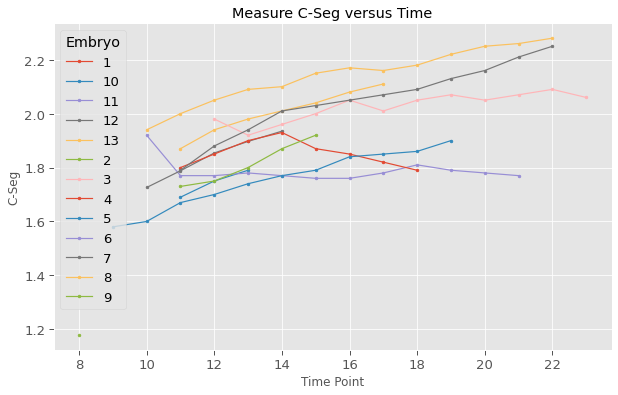

In [ ]:
#@title  { run: "auto" }
fig, ax = plt.subplots(figsize=(10,6))
fig.set_facecolor("white")
export_button(fig, "ref_vs_time.pdf")
x_measure = 'TimePoint'
y_measure = 'C-Seg' #@param ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 'C-Seg', 'Seg', 'C-HF']
ax.set_title(f"Measure {y_measure} versus Time")
ax.set_xlabel('Time Point')
ax.set_ylabel(y_measure)
groups = data_ref.groupby('Embryo')
for name, g in groups:
  ax.plot(g[x_measure],g[y_measure],'.-', label=name)
_ = plt.legend(title="Embryo")

# Expected intervals for isolated observations
For isolated observations, a ragente for the independent variable is computed such that the observed data point would fall withing an $n*\sigma$ confidence band aournd the regression line for the given mesaurement, where $n$ is chosen by the observer. For points falling outside the confidence band, a displacement in time units is computed, relativa to the nearest extreme of the allowed interval. 

Obsevation(C-HF,Seg): 1.4 0.5
For a 3.0 sigma interval, the expected interval for C-HF is: [0.5054,1.084]
Time displacement: 5.77

Obsevation(C-HF,Seg): 1.5 0.6
For a 3.0 sigma interval, the expected interval for C-HF is: [0.6121,1.19]
Time displacement: 5.71

Obsevation(C-HF,Seg): 1.4 1.0
For a 3.0 sigma interval, the expected interval for C-HF is: [1.039,1.617]
The C-HF value is within the expected interval.



Button(description='Export plot to PDF', style=ButtonStyle())

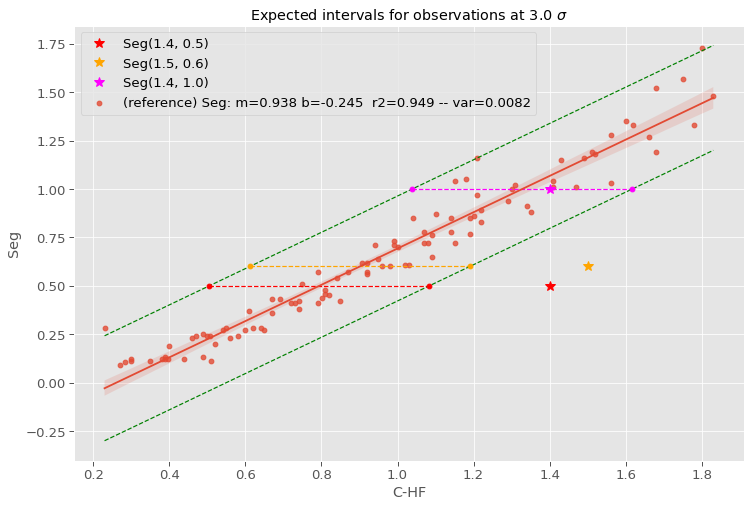

In [ ]:
#@title { run: "auto" }

fig, ax = plt.subplots(figsize=(12,8))
fig.set_facecolor('white')


data = data_ref.loc[:,'TimePoint':'C-HF']
time = 'TimePoint'
time_displacement = "Yes" #@param ["Yes", "No"]
time_displacement = time_displacement == "Yes"

# Menus
x_meas = 'C-HF' #@param ['C-HF']
y_meas= 'Seg' #@param ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 'C-Seg', 'Seg', 'C-HF']
sigma = '3' #@param ['1', '2', '3', '4']
sigma = float(sigma)
ax.set_title(f"Expected intervals for observations at {sigma} $\sigma$")

#@markdown Enter observations as (x,y) pairs separated by comas:
observations  = (1.4,0.5), (1.5,0.6), (1.4,1.0) #@param

obs_x, obs_y = zip(*observations)
if (len(obs_x) != len(obs_y)) :
  raise "The number of x and y observations must be the same"
if len(obs_x) * len(obs_y) == 0 :
  raise "Number of observations must be nonzero" 


# Need to drop data pairs with missing x 
if not time_displacement:
  temp_data = data[[x_meas,y_meas]].copy()
else:
  temp_data = data[[x_meas, y_meas, time]].copy()

temp_data.dropna(axis=0, how='any', inplace=True)

# sort the data points by x, or the plots will be garbled
x = np.array(temp_data.iloc[:,0])
y = np.array(temp_data.iloc[:,1])

sb.set_context("paper",font_scale=1.5)
_, m, b, r, yy_var = regplot_with_bands(ax=ax, x_var=x_meas, 
                                        y_var=y_meas,
                                        data=temp_data, sigma=sigma,
                                        limits=False,
                                        lb_prefix="(reference) ")

if time_displacement:
  t = np.array(temp_data.iloc[:,2])
  mt, bt, rt, _, _ = linregress(t, x)


bmin = b-sigma*np.sqrt(yy_var)
bmax = b+sigma*np.sqrt(yy_var)

from itertools import cycle
colors = ['red', 'orange','magenta','brown','black','gray']
iter_cl = cycle(colors)
# Plot the observed point
for ox, oy in zip(obs_x, obs_y) :
  if ox !=0 and oy != 0 :
    #if()
    cl = next(iter_cl)
    ax.plot(ox, oy,'*', ms=10, color=cl, label=y_meas+str((ox,oy)))
    vmax = (oy-bmin)/m
    vmin = (oy-bmax)/m
    ax.plot(vmin,oy,'o',color=cl)
    ax.plot(vmax,oy,'o',color=cl)
    ax.hlines(oy,vmin,
            vmax,
            colors=cl,
            linestyles='dashed')
    #print(80*'*')
    print(f"Obsevation({x_meas},{y_meas}):", ox, oy)
    print(f"For a {sigma} sigma interval, the expected",
        f"interval for {x_meas} is:",
        f"[{vmin:.4g},{vmax:.4g}]")
    if ox > vmin and ox < vmax :
      print(f"The {x_meas} value is within the expected interval.")
    else:
      if time_displacement:
        oxt = (ox-bt)/mt
        v = (oy-b)/m
        vt = (v-bt)/mt
        print(f"Time displacement: {oxt-vt:.3}")

    #print(80*'*')
    print()

_ = ax.legend()

export_button(fig, "expected_intervals.pdf")



# Confidence bands for single observations
Single observations of a given measurement over different embryos are plotted over the corresponding reference linear regression plot, with confidence bands. 

Button(description='Export plot to PDF', style=ButtonStyle())

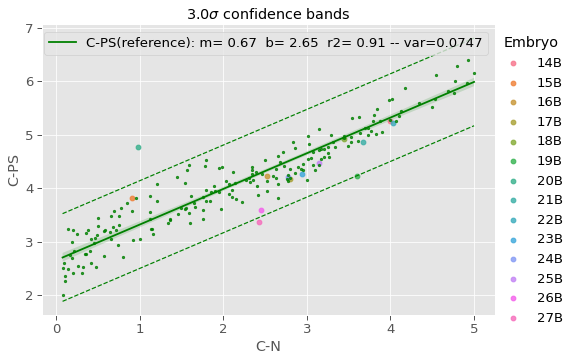

In [ ]:
#@title  { run: "auto" }

# Menus
include_zero = "No" #@param ['Yes', 'No']
include_zero = include_zero == "Yes"
x_meas = 'C-N' #@param ['C-N','C-HF', 'TimePoint']
y_meas= 'C-PS' #@param ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 'C-Seg', 'Seg', 'C-HF']
sigma = '3' #@param ['1', '2', '3', '4']
sigma = float(sigma)

if include_zero:
  data = data_xper_single
else:
  data=data_xper_single[~data_xper_single.TimePoint.isna()]

# The smbplot is required to plot the dataframe points
# with color according to embryo
# Notice that lmplot creates a figure object, and not
# an axis like regplot. So we need to run it first
g = sb.lmplot(x=x_meas,y=y_meas, aspect=1.5, 
              data=data,
              hue='Embryo',fit_reg=False)
#g = sb.lmplot(x='Med9',y='Med8',aspect=1.5, data=data_xper_single, fit_reg=False)
#fig, ax = plt.subplots(figsize=(15,10))
fig = plt.gcf()
fig.set_facecolor('white')
export_button(fig, "confidence_single.pdf")

g.ax.set_title(f"{sigma}$\sigma$ confidence bands")


# Need to drop data pairs with missing x or y
temp_data = data_ref[[x_meas,y_meas]].copy()
temp_data.dropna(axis=0, how='any', inplace=True)

x = np.array(temp_data.iloc[:,0])
y = np.array(temp_data.iloc[:,1])

# Sort points by value of measure x,
# to prevent garbled graphics
p = np.argsort(x)
x = x[p]
y = y[p]

# Estimate linear regression paramenters
m, b, r, _, _ = linregress(x, y)

# calc standard deviation of residuals
y_hat = m * x + b
yy = y - y_hat
yy_var = yy.var(ddof=2)
yy_std = np.sqrt(yy_var)


# Draw the sigma band lines around regression line
g.ax.plot(x, y_hat + sigma*yy_std,'g--')
g.ax.plot(x, y_hat - sigma*yy_std,'g--')

#g.ax.set_xlim()
#print(min(x),max(x))
#print(min(data[x_meas]),max(data[x_meas]))

label = f"{y_meas}(reference): m={m:5.2f}  b={b:5.2f}  r2={r*r:5.2f}"
label = label + f" -- var={yy_var:6.4f}"
# regplot will plot reference points and corresponding
# regression line
fig = plt.gcf()


sb.set_context("paper",font_scale=1.5)
_ = sb.regplot(x=x_meas, y=y_meas, data=data_ref,ax=g.ax,color='green', scatter_kws={'s':5})

_ = g.ax.legend(['_','_',label])



# Observations over time, compared to reference
Compares observations of a given measurement over time, done under different culture conditions, with the reference data for the same measurment.  

**** Culture type: H1
---- reference C-HF fitting parameters slope: 0.106, intercept: -0.584
---- this experiment fitting parameters slope: 0.133, intercept: 0.211
---- Y-axis displacement: -0.796

**** Culture type: pCat
---- reference C-HF fitting parameters slope: 0.106, intercept: -0.584
---- this experiment fitting parameters slope: 0.123, intercept: 0.216
---- Y-axis displacement: -0.801



Button(description='Export plot to PDF', style=ButtonStyle())

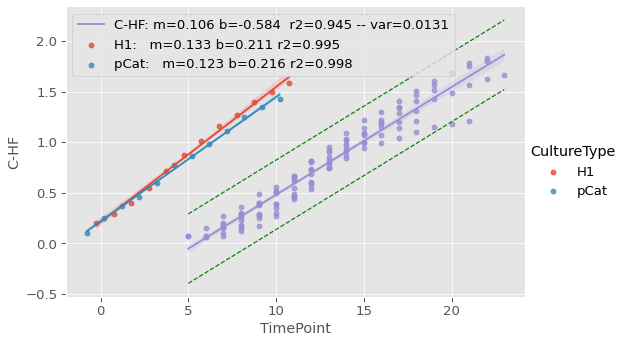

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title  { run: "auto" }

# Menus
x_meas = 'TimePoint' #@param ['C-N', 'C-HF', 'TimePoint']
y_meas= 'C-HF' #@param ['C-pPL', 'C-PS', 'C-N', 'N-pPL', 'PS', 'PSM', 'C-Seg', 'Seg', 'C-HF'] 
sigma = '3' #@param ['1', '2', '3', '4']
sigma = float(sigma)

#temp_data = data_xper_multi[[x_meas,y_meas,'Embriao']].copy()
#temp_data.dropna(axis=0, how='any', inplace=True)
temp_data = data_xper_multi[[x_meas,y_meas,'CultureType']].dropna(axis=0, how='any')
g = sb.lmplot(x=x_meas,y=y_meas, aspect=1.5, 
              data=temp_data,
              #data=data_xper_multi[[x_meas,y_meas,'Embriao']].dropna(axis=0, how='any'),
              hue='CultureType',fit_reg=False)
# compute linear regression of measured variable

groups = temp_data.groupby('CultureType')
labels = []
for name, gr in groups:
  #ax.plot(g[x_measure],g[y_measure],'.-', label=name)
  #_ = plt.legend(title="Embryo")

  x = np.array(gr.iloc[:,0])
  y = np.array(gr.iloc[:,1])
  mm, bm, rm, _, _ = linregress(x, y)
  labels.append(f"{name}:   m={mm:.3} b={bm:.3} r2={rm**2:.3}")

  print("**** Culture type:",name)
  print(f"---- reference {y_meas} fitting parameters",
        f"slope: {m:5.3f}, intercept: {b:5.3f}")
  print("---- this experiment fitting parameters",
        f"slope: {mm:5.3f}, intercept: {bm:5.3f}")
  print(f"---- Y-axis displacement: {b-bm:5.3f}")
  print()
  _ = sb.regplot(x=x_meas, y=y_meas, data=gr, 
               label=name,ax=g.ax, scatter=False)
#  _ = sb.regplot(x=x_meas, y=y_meas, data=data_xper_multi, 
#               label="",ax=g.ax,color='blue', scatter=False)


#
fig = plt.gcf()
fig.set_facecolor('white')
export_button(fig, "obs_vs_time_comp_ref.pdf")
legend_labels = ['_','_','_','_',label]+labels
label, m, b, r, var = regplot_with_bands(ax=g.ax, x_var=x_meas, y_var=y_meas, sigma=sigma,
                   data=data_ref, scatter=True,limits=False)
_ = g.ax.legend(legend_labels)
# Compute linear regressions and their relativa displacement
# x-Measure versus time for all embryos plus reference data
